# 라이브러리 import

In [1]:
import pickle
import os
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import numpy as np
import math
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn as nn
from time import time
from pprint import pprint
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.nn import TransformerEncoder
from torch.nn import TransformerDecoder
import matplotlib.pyplot as plt
import dateutil
from datetime import timedelta
from tqdm.notebook import trange
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
import seaborn as sns
from torchsummary import summary
from src.spot import SPOT
from src.pot import *

# TranAD 정의

In [2]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model).float() * (-math.log(10000.0) / d_model))
        pe += torch.sin(position * div_term)
        pe += torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x, pos=0):
        x = x + self.pe[pos:pos+x.size(0), :]
        return self.dropout(x)

class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=16, dropout=0):
        super(TransformerEncoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

        self.activation = nn.LeakyReLU(True)

    def forward(self, src,src_mask=None, src_key_padding_mask=None, **kwargs):
        src2 = self.self_attn(src, src, src)[0]
        src = src + self.dropout1(src2)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        return src

class TransformerDecoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=16, dropout=0):
        super(TransformerDecoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.multihead_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

        self.activation = nn.LeakyReLU(True)

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None,**kwargs):
        tgt2 = self.self_attn(tgt, tgt, tgt)[0]
        tgt = tgt + self.dropout1(tgt2)
        tgt2 = self.multihead_attn(tgt, memory, memory)[0]
        tgt = tgt + self.dropout2(tgt2)
        tgt2 = self.linear2(self.dropout(self.activation(self.linear1(tgt))))
        tgt = tgt + self.dropout3(tgt2)
        return tgt

class TranAD(nn.Module):
	def __init__(self, feats):
		super(TranAD, self).__init__()
		self.name = 'TranAD'
		self.lr = 0.001
		self.batch = 128
		self.n_feats = feats
		self.n_window = 96
		self.n = self.n_feats * self.n_window
		self.pos_encoder = PositionalEncoding(2 * feats, 0.1, self.n_window)
		encoder_layers = TransformerEncoderLayer(d_model=2 * feats, nhead=feats, dim_feedforward=16, dropout=0.1)
		self.transformer_encoder = TransformerEncoder(encoder_layers, 1)
		decoder_layers1 = TransformerDecoderLayer(d_model=2 * feats, nhead=feats, dim_feedforward=16, dropout=0.1)
		self.transformer_decoder1 = TransformerDecoder(decoder_layers1, 1)
		decoder_layers2 = TransformerDecoderLayer(d_model=2 * feats, nhead=feats, dim_feedforward=16, dropout=0.1)
		self.transformer_decoder2 = TransformerDecoder(decoder_layers2, 1)
		self.fcn = nn.Sequential(nn.Linear(2 * feats, feats), nn.Sigmoid())

	def encode(self, src, c, tgt):
		src = torch.cat((src, c), dim=2)
		src = src * math.sqrt(self.n_feats)
		src = self.pos_encoder(src)
		memory = self.transformer_encoder(src)
		tgt = tgt.repeat(1, 1, 2)
		return tgt, memory

	def forward(self, src, tgt):
		# Phase 1 - Without anomaly scores
		c = torch.zeros_like(src)
		x1 = self.fcn(self.transformer_decoder1(*self.encode(src, c, tgt)))
		# Phase 2 - With anomaly scores
		c = (x1 - src) ** 2
		x2 = self.fcn(self.transformer_decoder2(*self.encode(src, c, tgt)))
		return x1, x2

# HAI 데이터셋 가져오기

In [3]:
def dataframe_from_csv(target):
    return pd.read_csv(target).rename(columns=lambda x: x.strip())

def dataframe_from_csvs(targets):
    return pd.concat([dataframe_from_csv(x) for x in targets])

data = "PZR-COM-01"
TEST_DATASET = sorted([x for x in Path("./data/test/rx/com").glob("*.csv")])
TRAIN_DATASET = sorted([x for x in Path("./hai/train/").glob("*.csv")])
TEST_DF_RAW = dataframe_from_csv(f"./data/test/rx/com/{data}.csv")
TRAIN_DF_RAW = dataframe_from_csv("./data/train/rx/train.csv")

TEST_DF_RAW = TEST_DF_RAW.iloc[:12000]
TRAIN_DF_RAW = TRAIN_DF_RAW.iloc[:12000]

# TRAIN_DF_RAW = dataframe_from_csvs(TRAIN_DATASET)
# TRAIN_DF_RAW.reset_index(drop=True,inplace=True)
print(TRAIN_DF_RAW.shape)
TRAIN_DF_RAW.head()

(12000, 128)


,time,bufss[1],enfms.NFSC_LIN[0],txMPJI003.Output,rrsTAVG.Output6_r8,rrsTREF.Output6_r8,rrsTERR.Output6_r8,txRCTE132A.Output,txRCTE133A.Output,txRCTE142A.Output,...,ctFWHIC1112.ixvInputReal,ctFWHIC1113.anvSP_Real,ctFWHIC1113.anvCmd100,ctFWHIC1113.ixvInputReal,ctFWHIC1122.anvSP_Real,ctFWHIC1122.anvCmd100,ctFWHIC1122.ixvInputReal,ctFWHIC1123.anvSP_Real,ctFWHIC1123.anvCmd100,ctFWHIC1123.ixvInputReal
0,0,4013.75,99.9519,1492.5,307.205,307.2,0.005341,323.774,323.695,290.672,...,0,50,50,0,61.2578,61.2578,0,50,50,0
1,0.1,4013.75,99.9519,1492.5,307.205,307.2,0.005338,323.774,323.695,290.672,...,0,50,50,0,61.2581,61.2581,0,50,50,0
2,0.2,4013.75,99.9519,1492.5,307.205,307.2,0.005336,323.774,323.695,290.672,...,0,50,50,0,61.2583,61.2583,0,50,50,0
3,0.3,4013.75,99.9519,1492.5,307.205,307.2,0.005333,323.774,323.695,290.672,...,0,50,50,0,61.2584,61.2584,0,50,50,0
4,0.4,4013.75,99.9519,1492.5,307.205,307.2,0.005331,323.774,323.695,290.672,...,0,50,50,0,61.2586,61.2586,0,50,50,0


# HAI 데이터셋 전처리

In [4]:
TIMESTAMP_FIELD = "time"
# ATTACK_FIELD = "Attack"
NOT_VALID_FIELD = ["time"]
# ATTACK_DF = TRAIN_DF_RAW["Attack"]
VALID_COLUMNS_IN_TRAIN_DATASET = TEST_DF_RAW.columns.drop(NOT_VALID_FIELD)

# MIN-MAX 정규화 적용

In [5]:
def normalize(df, TAG_MIN, TAG_MAX):
    ndf = df.copy()
    for c in df.columns:
        if TAG_MIN[c] == TAG_MAX[c]:
            ndf[c] = df[c] - TAG_MIN[c]
        else:
            ndf[c] = (df[c] - TAG_MIN[c]) / (TAG_MAX[c] - TAG_MIN[c])
    return ndf

In [6]:
TAG_MIN_TRAIN = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].min()
TAG_MAX_TRAIN = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].max()
TAG_MIN_TEST = TEST_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].min()
TAG_MAX_TEST = TEST_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].max()
TAG_MIN = np.minimum(TAG_MIN_TRAIN, TAG_MIN_TEST)
TAG_MAX = np.maximum(TAG_MAX_TRAIN, TAG_MAX_TEST)

TRAIN_DF = normalize(TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET][:10000], TAG_MIN, TAG_MAX)
TEST_DF = normalize(TEST_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET], TAG_MIN, TAG_MAX)

# 정규화 범위 체크(훈련 데이터)

In [7]:
def boundary_check(df):
    x = np.array(df, dtype=np.float32)
    return np.any(x > 1.0), np.any(x < 0), np.any(np.isnan(x))

# Boundary Check
print(boundary_check(TRAIN_DF))
print(boundary_check(TEST_DF))

(False, False, False)
(False, False, False)


# 정규화 된 데이터 > 슬라이딩 윈도우로 데이터 처리

In [8]:
def convert_to_windows(data):
	windows = []; w_size = 96
	for i, g in enumerate(data): 
		if i >= w_size: w = data[i-w_size:i]
		else: w = torch.cat([data[0].repeat(w_size-i, 1), data[0:i]])
		windows.append(w)
	return torch.stack(windows)


# 변수 추출

상관관계를 구해서 관련성이 높은 변수들만 추출 후 특성으로 사용

In [9]:
feature_columns = ['P1_B2016', 'P4_ST_PO', 'P4_LD', 'P1_PIT01', 'P4_ST_PT01', 'P1_FT03', 'P1_FT03Z',
                   'P1_PCV01D', 'P1_PCV01Z', 'P3_LT01', 'P1_LCV01D', 'P1_LCV01Z', 'P1_FT01',
                   'P1_FT01Z', 'P3_LCV01D', 'P4_HT_PO', 'P4_LD']

trainO = torch.from_numpy(TRAIN_DF.to_numpy())
trainD = torch.from_numpy(TRAIN_DF.to_numpy())

trainD = convert_to_windows(trainD)
print(trainD.shape, trainO.shape)

torch.Size([10000, 96, 127]) torch.Size([10000, 127])


# 처음 훈련할 때 사용할 모델 선정

In [10]:
#훈련할 때

model = TranAD(trainD.shape[-1]).float()
optimizer = torch.optim.AdamW(model.parameters() , lr=model.lr, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5, 0.9)
epoch = -1;
accuracy_list = []

/root/junseo/lib/python3.10/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer was not TransformerEncoderLayer
  warnings.warn(


# 역전파 함수

- 훈련할 때 역전파를 하기 위한 코드
- 테스트할 때는 값을 예측 하기 위해 사용


In [11]:

def backprop_modify(
    epoch,
    model,
    data,
    dataO,
    optimizer,
    scheduler,
    training: bool = True,
    eval_bs: int | None = None,     # 평가 배치 크기
    device: torch.device | None = None,
    dtype: torch.dtype = torch.float32,
    num_workers: int = 0,           # OOM 피하려면 0 권장
    pin_memory: bool = False
):
    feats = dataO.shape[1]
    l = nn.MSELoss(reduction='none')

    # Tensor 준비 (fp32 권장)
    data_x = torch.tensor(data, dtype=dtype)
    dataset = TensorDataset(data_x, data_x)

    # 디바이스
    if device is None:
        device = next(model.parameters()).device

    # 배치 크기
    if training:
        bs = getattr(model, 'batch', 256)
    else:
        # 평가 배치 크기(없으면 모델 batch 또는 256)
        bs = eval_bs or getattr(model, 'batch', 256)
        bs = max(1, min(bs, len(data)))  # 안전 가드

    dataloader = DataLoader(
        dataset,
        batch_size=bs,
        shuffle=training,
        num_workers=num_workers,
        pin_memory=pin_memory
    )

    n = epoch + 1
    l1s = []

    if training:
        model.train()
        for d, _ in dataloader:
            d = d.to(device, dtype=dtype, non_blocking=pin_memory)  # (B, W, F)
            local_bs = d.shape[0]

            window = d.permute(1, 0, 2)                # (W, B, F)
            elem = window[-1, :, :].view(1, local_bs, feats)

            z = model(window, elem)
            l1 = l(z, elem) if not isinstance(z, tuple) \
                 else (1/n) * l(z[0], elem) + (1 - 1/n) * l(z[1], elem)
            if isinstance(z, tuple):
                z = z[1]

            l1s.append(torch.mean(l1).item())
            loss = torch.mean(l1)

            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()

        if scheduler is not None:
            scheduler.step()

        tqdm.write(f'Epoch {epoch},\tL1 = {np.mean(l1s):.6f}')
        return float(np.mean(l1s)), optimizer.param_groups[0]['lr']

    else:
        model.eval()
        all_losses = []
        all_preds = []
        with torch.no_grad():
            for d, _ in dataloader:
                d = d.to(device, dtype=dtype, non_blocking=pin_memory)  # (B, W, F)
                local_bs = d.shape[0]

                window = d.permute(1, 0, 2)            # (W, B, F)
                elem = window[-1, :, :].view(1, local_bs, feats)

                z = model(window, elem)
                if isinstance(z, tuple):
                    z = z[1]

                # 원래 코드 형태 유지: (1, B, F) -> [0]로 (B, F)
                loss_mat = l(z, elem)[0].cpu()
                pred_mat = z[0].cpu()

                all_losses.append(loss_mat)
                all_preds.append(pred_mat)

        loss_full = torch.cat(all_losses, dim=0).numpy()  # (N, F)
        pred_full = torch.cat(all_preds, dim=0).numpy()   # (N, F)
        return loss_full, pred_full


# 그래프 그리는 함수

훈련 과정중 발생하는 loss값을 그래프로 표현.

In [12]:
def plot_accuracies(accuracy_list, folder):
	os.makedirs(f'plots/{folder}/', exist_ok=True)
	trainAcc = [i[0] for i in accuracy_list]
	lrs = [i[1] for i in accuracy_list]
	plt.xlabel('Epochs')
	plt.ylabel('Average Training Loss')
	plt.plot(range(len(trainAcc)), trainAcc, label='Average Training Loss', linewidth=1, linestyle='-', marker='.')
	plt.twinx()
	plt.plot(range(len(lrs)), lrs, label='Learning Rate', color='r', linewidth=1, linestyle='--', marker='.')
	plt.savefig(f'plots/{folder}/training-graph.pdf')

# 훈련된 모델 저장하는 함수

In [13]:
def save_model(model, optimizer, scheduler, epoch, accuracy_list):
	folder = f'./model/rx/{data}'
	os.makedirs(folder, exist_ok=True)
	file_path = f'{folder}/{data}.ckpt'
	torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'accuracy_list': accuracy_list}, file_path)

# 훈련이 끝난 모델 불러오는 함수

# 모델 훈련 코드

/tmp/ipykernel_3666552/2588945088.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_x = torch.tensor(data, dtype=dtype)


Epoch 0,	L1 = 0.009299


 20%|█████████████████                                                                    | 1/5 [01:03<04:15, 63.88s/it]

Epoch 0,	L1 = 0.000506


 40%|██████████████████████████████████                                                   | 2/5 [02:10<03:15, 65.28s/it]

Epoch 1,	L1 = 0.003467


 60%|███████████████████████████████████████████████████                                  | 3/5 [03:17<02:12, 66.27s/it]

Epoch 2,	L1 = 0.000357


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [04:24<01:06, 66.55s/it]

Epoch 3,	L1 = 0.000261


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:31<00:00, 66.24s/it]

Epoch 4,	L1 = 0.000206


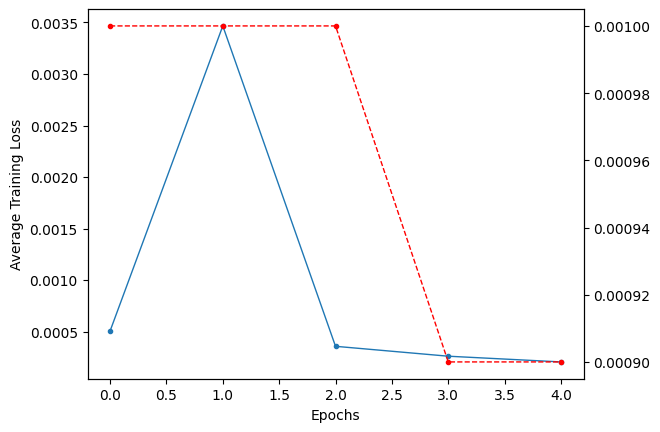

In [14]:
num_epochs = 5; e = epoch + 1; start = time()
backprop_modify(e, model, trainD, trainO, optimizer, scheduler)
for e in tqdm(list(range(epoch+1, epoch+num_epochs+1))):
  lossT, lr = backprop_modify(e, model, trainD, trainO, optimizer, scheduler)
  accuracy_list.append((lossT, lr))
plot_accuracies(accuracy_list, 'TranAD')
save_model(model, optimizer, scheduler, e, accuracy_list)

# 스무딩 적용 함수

In [15]:
def smooth(y, box_pts=1):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

# 테스트 데이터 정규화

In [16]:
testO = torch.from_numpy(TEST_DF.to_numpy())
testD = torch.from_numpy(TEST_DF.to_numpy())

testD = convert_to_windows(testD)
print(testD.shape, testO.shape)

torch.Size([12000, 96, 127]) torch.Size([12000, 127])


# 훈련된 모델 평가

In [17]:
### Testing phase
torch.zero_grad = True
model.eval()
#print(f'{color.HEADER}Testing {args.model} on {args.dataset}{color.ENDC}')
loss, y_pred = backprop_modify(0, model, testD, testO, optimizer, scheduler, training=False)

/tmp/ipykernel_3666552/2588945088.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_x = torch.tensor(data, dtype=dtype)


In [18]:
print(loss.shape, y_pred.shape)

(12000, 127) (12000, 127)


# 정답 라벨 전처리

In [19]:
# ATTACK_DF_TEST = Label_DF_RAW["label"]
# label = ATTACK_DF_TEST[:19940]
labels = np.zeros(TEST_DF_RAW.shape[0])
labels[6000:] = 1
labels = np.tile(labels, (loss.shape[1], 1)).T
print(len(labels))

12000


In [20]:
def hit_att(ascore, labels, ps = [100, 150]):
	res = {}
	for p in ps:
		hit_score = []
		for i in range(ascore.shape[0]):
			a, l = ascore[i], labels[i]
			a, l = np.argsort(a).tolist()[::-1], set(np.where(l == 1)[0])
			if l:
				size = round(p * len(l) / 100)
				a_p = set(a[:size])
				intersect = a_p.intersection(l)
				hit = len(intersect) / len(l)
				hit_score.append(hit)
		res[f'Hit@{p}%'] = np.mean(hit_score)
	return res

def ndcg(ascore, labels, ps = [100, 150]):
	res = {}
	for p in ps:
		ndcg_scores = []
		for i in range(ascore.shape[0]):
			a, l = ascore[i], labels[i]
			labs = list(np.where(l == 1)[0])
			if labs:
				k_p = round(p * len(labs) / 100)
				try:
					hit = ndcg_score(l.reshape(1, -1), a.reshape(1, -1), k = k_p)
				except Exception as e:
					return {}
				ndcg_scores.append(hit)
		res[f'NDCG@{p}%'] = np.mean(ndcg_scores)
	return res


In [21]:
lossT, _ = backprop_modify(0, model, trainD, trainO, optimizer, scheduler, training=False)

/tmp/ipykernel_3666552/2588945088.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_x = torch.tensor(data, dtype=dtype)


In [22]:
df = pd.DataFrame()
for i in range(loss.shape[1]):
		lt, l, ls = lossT[:, i], loss[:, i], labels[:, i]
		result, pred = pot_eval(lt, l, ls); preds.append(pred)
		df = pd.concat([df, pd.DataFrame([result])], ignore_index=True)

In [23]:
lossTfinal, lossFinal = np.mean(lossT, axis=1), np.mean(loss, axis=1)
labelsFinal = (np.sum(labels, axis=1) >= 1) + 0
result, _ = pot_eval(lossTfinal, lossFinal, labelsFinal)

In [24]:
result.update(hit_att(loss, labels))
result.update(ndcg(loss, labels))

In [25]:
print(df)
pprint(result)

           f1  precision  recall      TP      TN      FP   FN   ROC/AUC  \
0    0.671587   0.505561     1.0  6000.0   132.0  5868.0  0.0  0.511000   
1    0.668035   0.501546     1.0  6000.0    37.0  5963.0  0.0  0.503083   
2    0.668333   0.501882     1.0  6000.0    45.0  5955.0  0.0  0.503750   
3    0.673207   0.507400     1.0  6000.0   175.0  5825.0  0.0  0.514583   
4    0.668631   0.502218     1.0  6000.0    53.0  5947.0  0.0  0.504417   
..        ...        ...     ...     ...     ...     ...  ...       ...   
122  0.681620   0.517019     1.0  6000.0   395.0  5605.0  0.0  0.532917   
123  0.668184   0.501714     1.0  6000.0    41.0  5959.0  0.0  0.503417   
124  0.999995   1.000000     1.0  6000.0  6000.0     0.0  0.0  1.000000   
125  0.999995   1.000000     1.0  6000.0  6000.0     0.0  0.0  1.000000   
126  0.668370   0.501924     1.0  6000.0    46.0  5954.0  0.0  0.503833   

     threshold  
0     0.000002  
1     0.000017  
2     0.000003  
3     0.000028  
4     0.000028

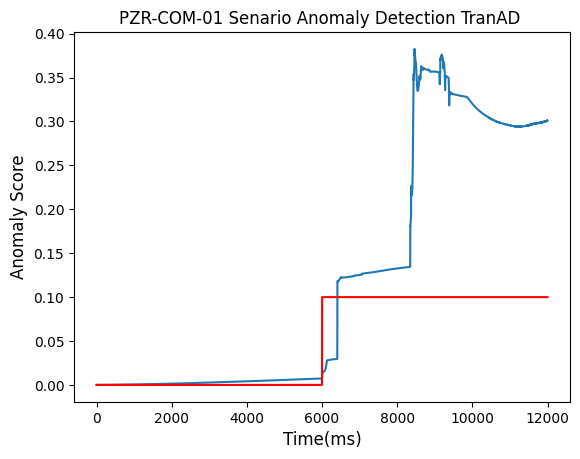

In [26]:
plt.plot(lossFinal)
plt.title(f"{data} Senario Anomaly Detection TranAD ")
plt.xlabel('Time(ms)', fontsize=12)
plt.ylabel('Anomaly Score', fontsize=12)
plt.plot(labelsFinal * 0.1, color = 'red')
plt.show()